# Conjugate Priors

In [1]:
include("utils.jl"); using .Utils
checkpkgs("Distributions", "Plots", "DataFrames")

## The World Cup Problem Revisited

In [2]:
using Distributions
α=1.4
dist = Gamma(α)

Gamma{Float64}(α=1.4, θ=1.0)

In [3]:
include("empiricaldist.jl"); using .EmpiricalDist
lams = LinRange(0, 10, 101)
prior = pmffromdist(dist, lams);

In [4]:
k = 4
likelihood = pdf.(Poisson.(lams),k);

In [5]:
posterior = prior .* likelihood
normalize!(posterior)

0.05015532557804502

## The Conjugate Prior

In [6]:
"""Makes a gamma object."""
make_gamma_dist(α, β) = Gamma(α, 1/β)

make_gamma_dist

In [7]:
α = 1.4
β = 1

prior_gamma = make_gamma_dist(α, β)
mean(prior_gamma)

1.4

In [8]:
"""Update a gamma prior."""
function update_gamma(prior, data)
    k, t = data
    αₚ, θₚ=params(prior)
    βₚ=1/θₚ
    α = αₚ + k
    β = βₚ + t
    return make_gamma_dist(α, β)
end

update_gamma

In [9]:
data = 4, 1
posterior_gamma = update_gamma(prior_gamma, data)

Gamma{Float64}(α=5.4, θ=0.5)

In [10]:
posterior_conjugate = pmffromdist(posterior_gamma, lams);

In [11]:
using Plots
function decorate_rate!(title="")
    plot!(xlabel="Goal scoring rate (lam)",
             ylabel="PMF",
             title=title)
end

decorate_rate! (generic function with 2 methods)

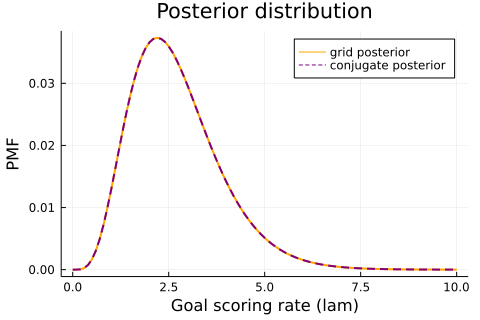

In [12]:
plot(posterior, label="grid posterior", color=:orange)
plot!(posterior_conjugate, label="conjugate posterior", 
                         color=:purple, ls=:dash)

decorate_rate!("Posterior distribution")

In [13]:
isapprox(posterior, posterior_conjugate)

true

## What the Actual?

## Binomial Likelihood

In [14]:
xs = LinRange(0, 1, 101)
uniform = makeuniform(xs, name="uniform");

In [15]:
k, n = 140, 250
xs = uniform.qs
likelihood = pdf.(Binomial.(n, xs), k);

In [16]:
posterior = uniform .* likelihood
normalize!(posterior)

0.003944617569326678

In [17]:
"""Makes a beta object."""
make_beta(α, β) = Beta(α, β)

make_beta

In [18]:
α = 1
β = 1

prior_beta = make_beta(α, β)

Beta{Float64}(α=1.0, β=1.0)

In [19]:
params(prior_beta)

(1.0, 1.0)

In [20]:
"""Update a beta distribution."""
function update_beta(prior, data)
    k, n = data
    αₚ, βₚ=params(prior)
    α = αₚ + k
    β = βₚ + n - k
    return make_beta(α, β)
end

update_beta

In [21]:
data = 140, 250
posterior_beta = update_beta(prior_beta, data)

Beta{Float64}(α=141.0, β=111.0)

In [22]:
posterior_conjugate = pmffromdist(posterior_beta, xs);

In [23]:
function decorate_euro!(title)
    plot!(xlabel="Proportion of heads (x)",
             ylabel="Probability",
             legend=:topleft,
             title=title)
end

decorate_euro! (generic function with 1 method)

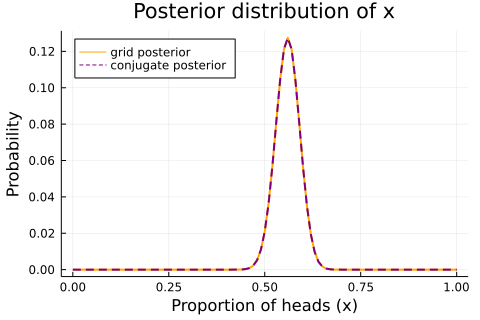

In [24]:
plot(posterior, label="grid posterior", color=:orange)
plot!(posterior_conjugate, label="conjugate posterior",
                        color=:purple, ls=:dash)

decorate_euro!("Posterior distribution of x")

In [25]:
isapprox(posterior, posterior_conjugate)

true

## Lions and Tigers and Bears

In [26]:
data = [3, 2, 1]
n = sum(data)
ps = [0.4, 0.3, 0.3]

pdf(Multinomial(n, ps), data)

0.10368000000000008

## The Dirichlet Distribution

In [27]:
alpha = [1, 2, 3]
dist = Dirichlet(alpha)

Dirichlet{Int64, Vector{Int64}, Float64}(alpha=[1, 2, 3])

In [28]:
rand(dist)

3-element Vector{Float64}:
 0.1647248320248212
 0.17303356805521286
 0.6622415999199659

In [29]:
sum(rand(dist))

0.9999999999999999

In [30]:
sampl = rand(dist, 1000)';

In [31]:
size(sampl)

(1000, 3)

In [32]:
cdfs = [cdffromseq(col) 
        for col in eachcol(sampl)];

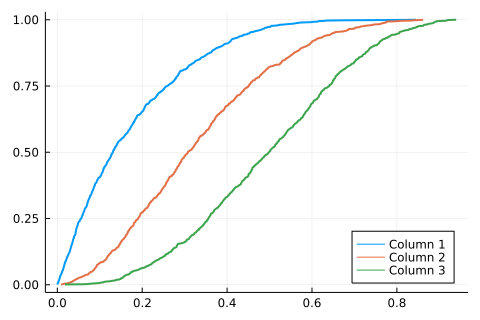

In [33]:
plot()
for (i, cdf) in enumerate(cdfs)
    label = "Column $i"
    plot!(cdf, label=label)
end
plot!(legend=:bottomright)

In [34]:
"""Compute the ith marginal of a Dirichlet distribution."""
function marginal_beta(α, i)
    total = sum(α)
    return make_beta(α[i], total-α[i])
end

marginal_beta

In [35]:
marginals = [marginal_beta(alpha, i)
             for i in 1:length(alpha)]

3-element Vector{Beta{Float64}}:
 Beta{Float64}(α=1.0, β=5.0)
 Beta{Float64}(α=2.0, β=4.0)
 Beta{Float64}(α=3.0, β=3.0)

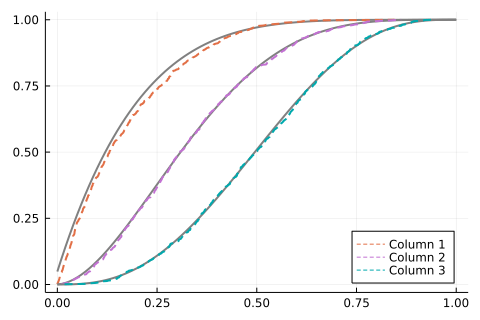

In [36]:
xs = LinRange(0, 1, 101)
plot()
for i in 1:length(alpha)
    label = "Column $i"
    
    pmf = pmffromdist(marginals[i], xs)
    plot!(makecdf(pmf), color=:gray, label="")
    
    cdf = cdfs[i]
    plot!(cdf, label=label, ls=:dash)
end
plot!(legend=:bottomright)

## Summary

In [37]:
# Solution

"""
The unnormalized posterior is

λ^{α-1+1} e^{-(β + t) λ}

which is an unnormalized gamma distribution with parameters
`α+1` and `β+t`, which means that we observed 1 goal
in elapsed time `t`.

So we can use the same update function and call it like this:
"""

data = 1, 11/90
posterior1 = update_gamma(prior_gamma, data)

Gamma{Float64}(α=2.4, θ=0.8910891089108911)

In [38]:
# Solution

# Here's the second update

data = 1, 12/90
posterior2 = update_gamma(posterior1, data)

Gamma{Float64}(α=3.4, θ=0.7964601769911505)

In [39]:
# Solution

mean(prior_gamma), mean(posterior1), mean(posterior2)

(1.4, 2.1386138613861387, 2.7079646017699113)

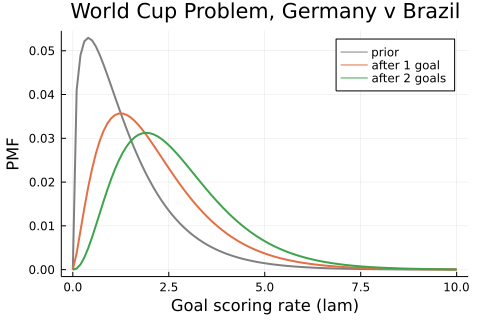

In [50]:
# Solution

# And here's what the posteriors look like

plot(pmffromdist(prior_gamma, lams), color=:gray, label="prior", legend=:topright)
plot!(pmffromdist(posterior1, lams), label="after 1 goal")
plot!(pmffromdist(posterior2, lams), label="after 2 goals")

decorate_rate!("World Cup Problem, Germany v Brazil")

In [44]:
ramp_up = 0:49
ramp_down = 50:-1:0

a = vcat(ramp_up, ramp_down)
xs = uniform.qs

triangle = Pmf(a, xs, name="triangle")
normalize!(triangle)

2500.0

In [45]:
k, n = 140, 250
likelihood = pdf.(Binomial.(n, xs), k)

posterior = triangle .* likelihood
normalize!(posterior)

0.0070088425900591365

In [47]:
alpha = 1
beta = 1

prior_beta = make_beta(alpha, beta)
mean(prior_beta)

0.5

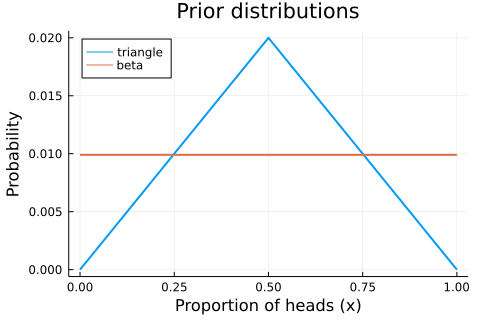

In [54]:
prior_pmf = pmffromdist(prior_beta, xs)


plot(triangle, label="triangle")
plot!(prior_pmf, label="beta")

decorate_euro!("Prior distributions")

In [55]:
# Solution

data = 140, 250
posterior_beta = update_beta(prior_beta, data)
mean(posterior_beta)

0.5595238095238095

In [56]:
# Solution

posterior_conjugate = pmffromdist(posterior_beta, xs);

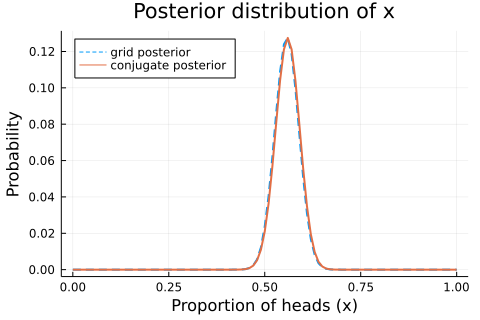

In [58]:
# Solution

plot(posterior, label="grid posterior", ls=:dash)
plot!(posterior_conjugate, label="conjugate posterior")

plot!(xlabel="Proportion of heads (x)",
         ylabel="Probability",
         title="Posterior distribution of x",
         legend=:topleft)

In [59]:
# Solution

# The largest absolute difference is pretty small

isapprox(posterior, posterior_conjugate)

false

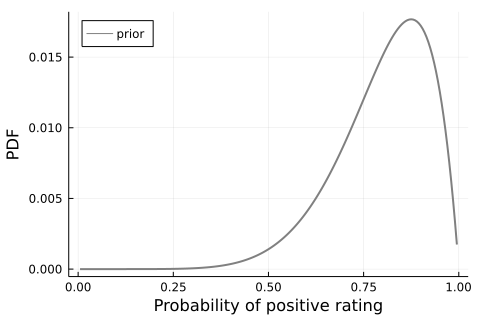

In [61]:
# Solution

# The first prior implies that most sellers are 
# satisfactory most of the time, but none are perfect.

prior = make_beta(8, 2)

xs = LinRange(0.005, 0.995, 199)
prior_pmf = pmffromdist(prior, xs)
plot(prior_pmf, color=:gray, label="prior",
         xlabel="Probability of positive rating",
         ylabel="PDF", legend=:topleft)

In [63]:
# Solution

data1 = 10, 10
data2 = 48, 50
data3 = 186, 200;

In [64]:
# Solution

seller1 = update_beta(prior, data1)
seller2 = update_beta(prior, data2)
seller3 = update_beta(prior, data3);

In [65]:
# Solution

seller1_pmf = pmffromdist(seller1, xs)
seller2_pmf = pmffromdist(seller2, xs)
seller3_pmf = pmffromdist(seller3, xs);

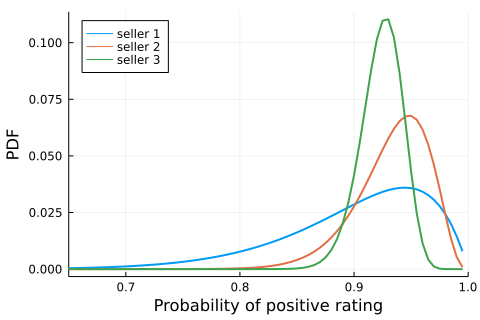

In [67]:
# Solution

plot(seller1_pmf, label="seller 1")
plot!(seller2_pmf, label="seller 2")
plot!(seller3_pmf, label="seller 3")

plot!(xlabel="Probability of positive rating",
         ylabel="PDF",
         xlim=(0.65, 1.0), legend=:topleft)

In [68]:
# Solution

mean(seller1), mean(seller2), mean(seller3)

(0.9, 0.9333333333333333, 0.9238095238095239)

In [71]:
# Solution

iters = 10000
a = Matrix(undef, 3, iters)

a[1, :] .= rand(seller1, iters)
a[2, :] .= rand(seller2, iters)
a[3, :] .= rand(seller3, iters);

In [87]:
best = [x[1] for x in argmax(a, dims=1)]
pmffromseq(best)

┌───┬────────┐
│   │  probs │
├───┼────────┤
│ 1 │ 0.2901 │
│ 2 │ 0.4867 │
│ 3 │ 0.2232 │
└───┴────────┘


In [88]:
# Solution

prior_alpha = [1, 1, 1]
data = 3, 2, 1

(3, 2, 1)

In [91]:
# Solution

posterior_alpha = prior_alpha .+ data;

In [93]:
# Solution

marginal_bear = marginal_beta(posterior_alpha, 3)
mean(marginal_bear)

0.2222222222222222

In [94]:
# Solution

dist = Dirichlet(posterior_alpha)

Dirichlet{Int64, Vector{Int64}, Float64}(alpha=[4, 3, 2])

In [98]:
# Solution
using DataFrames

DataFrame(:index => ["lion", "tiger", "bear"], :probs => mean(dist))

,index,probs
,String,Float64
1,lion,0.444444
2,tiger,0.333333
3,bear,0.222222
